In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from astropy.io import ascii
from utils import *
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
datasets = "../datasets/SuperCOSMOS/"
uki823_df = ascii.read(datasets + "UKI823/sssedrpair.dat").to_pandas()

In [3]:
uki823_df.columns = col_names
#ukr823_df.columns = col_names
#ukj823_df.columns = col_names
uki823_df.head()

,RA,DEC,XMIN,XMAX,YMIN,YMAX,AREA,IPEAK,COSMAG,ISKY,...,"N(0,1)",PRFMAG,C_COSMAG,C_PRFMAG,RA_SDSS,DEC_SDSS,GMAG_SDSS,RMAG_SDSS,IMAG_SDSS,CLASS_SDSS
0,627905166,-1862044,22405186,22421181,10590948,10604948,161,42793408,-22923,17532226,...,-777,-23019,15.639,14.998,359.763288,-1.067042,19.127230,17.637123,15.888538,6
1,628109952,-662364,21782348,21792346,14279944,14289944,46,5089298,-20025,18211806,...,4639,-20435,17.703,17.800,359.880409,-0.379610,19.122244,18.505545,18.302338,6
2,628195987,-1076412,21517417,21529414,13006944,13018944,87,17260390,-21479,17841694,...,-51,-21669,16.723,16.460,359.929869,-0.616716,19.118631,17.716108,17.013582,6
3,628311942,-518403,21162509,21172507,14721942,14731942,57,7749678,-20599,18688688,...,-259,-20958,17.357,17.232,359.996295,-0.297037,19.114597,18.120455,17.692406,6
4,627218041,-1032678,24519637,24532633,13137958,13149958,84,14814466,-21295,17692354,...,111,-21519,16.848,16.623,359.369486,-0.591688,19.112507,17.852146,17.173191,6


In [4]:
uki823_df.describe()

,RA,DEC,XMIN,XMAX,YMIN,YMAX,AREA,IPEAK,COSMAG,ISKY,...,"N(0,1)",PRFMAG,C_COSMAG,C_PRFMAG,RA_SDSS,DEC_SDSS,GMAG_SDSS,RMAG_SDSS,IMAG_SDSS,CLASS_SDSS
count,1.564500e+04,1.564500e+04,1.564500e+04,1.564500e+04,1.564500e+04,1.564500e+04,15645.000000,1.564500e+04,15645.000000,1.564500e+04,...,15645.000000,15645.000000,15645.000000,15645.000000,15645.000000,15645.000000,15645.000000,15645.000000,15645.000000,15645.000000
mean,3.037003e+08,8.493844e+04,2.101054e+07,2.102133e+07,1.657487e+07,1.658549e+07,92.001151,1.319364e+07,-20152.272867,1.808098e+07,...,2716.035986,-20838.007670,17.481817,17.367207,174.007529,0.048635,19.528314,18.495397,17.893314,4.885331
std,3.131201e+08,1.264880e+06,3.094560e+06,3.094725e+06,3.885662e+06,3.885580e+06,314.990581,1.817166e+07,1971.753396,4.441520e+05,...,3628.301001,1759.041618,1.285655,1.894035,179.404607,0.724706,2.194382,1.931732,1.773068,1.449708
min,1.440000e+02,-2.170521e+06,1.578191e+07,1.579490e+07,9.640962e+06,9.652950e+06,8.000000,1.297920e+06,-28893.000000,1.709983e+07,...,-8899.000000,-34317.000000,11.154000,4.781000,0.000165,-1.243447,8.985260,6.618781,6.940934,3.000000
25%,8.761940e+05,-9.941590e+05,1.829625e+07,1.830425e+07,1.326194e+07,1.327096e+07,17.000000,2.348600e+06,-21393.000000,1.769842e+07,...,153.000000,-21599.000000,16.776000,16.536000,0.502112,-0.569497,18.465448,17.573668,17.055212,3.000000
50%,1.691507e+06,1.317640e+05,2.097056e+07,2.098055e+07,1.671895e+07,1.672794e+07,37.000000,3.912512e+06,-19703.000000,1.802993e+07,...,2189.000000,-20233.000000,17.858000,18.019000,0.969110,0.075373,19.967171,18.960104,18.355196,6.000000
75%,6.274335e+08,1.190811e+06,2.367885e+07,2.368885e+07,1.997294e+07,1.998294e+07,92.000000,1.417421e+07,-18561.000000,1.845908e+07,...,4545.000000,-19562.000000,18.471000,18.748000,359.492904,0.682301,21.087143,19.793398,19.087181,6.000000
max,6.283183e+08,2.222493e+06,2.651011e+07,2.654111e+07,2.313795e+07,2.315595e+07,24006.000000,1.210549e+08,-17410.000000,1.899585e+07,...,102961.000000,-18962.000000,19.292000,19.399000,359.999933,1.273383,22.999374,24.802490,27.166468,6.000000


In [5]:
#Normalise SDSS class labels. Form confusion matrix
normalise_sdss_class(uki823_df)
uki823_df[['CLASS', 'CLASS_SDSS']]
confusion_matrix(uki823_df['CLASS'], uki823_df['CLASS_SDSS'])

array([[4537, 3612,    0,    0],
       [1225, 6191,    0,    0],
       [  11,    2,    0,    0],
       [  40,   27,    0,    0]])

In [6]:
#Create first raw dataset
data_x_raw = uki823_df.iloc[:,:-1]
data_y_raw =uki823_df['CLASS_SDSS']

In [7]:
#Split raw dataset into raw train,val,test sets
from sklearn.model_selection import train_test_split
random_state = 1
X_train_raw,X_test_raw,y_train,y_test = train_test_split(data_x_raw,data_y_raw,test_size=0.1,random_state=random_state)
X_train_raw,X_val_raw,y_train,y_val = train_test_split(X_train_raw,y_train,test_size=2./9,random_state=random_state)

In [8]:
X_train_raw.columns

Index(['RA', 'DEC', 'XMIN', 'XMAX', 'YMIN', 'YMAX', 'AREA', 'IPEAK', 'COSMAG',
       'ISKY', 'XCEN_I', 'YCEN_I', 'A_U', 'B_U', 'THETA_U', 'A_I', 'B_I',
       'THETA_I', 'CLASS', 'P_A', 'AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6',
       'AP7', 'AP8', 'BLEND', 'QUALITY', 'N(0,1)', 'PRFMAG', 'C_COSMAG',
       'C_PRFMAG', 'RA_SDSS', 'DEC_SDSS', 'GMAG_SDSS', 'RMAG_SDSS',
       'IMAG_SDSS'],
      dtype='object')

In [9]:
#Define classification function
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,roc_auc_score

def Classify_Function(x_train,y_train,x_val,y_val):
    names = ["Logistic Regression", #"Linear SVM", "RBF SVM",
             "Decision Tree", "Random Forest", "Neural Net (Multi-layer perceptron)"]

    classifiers = [
        LogisticRegression(),
        #SVC(kernel="linear", probability=True, random_state=random_state),
        #SVC(kernel='rbf', probability=True, random_state=random_state),
        DecisionTreeClassifier(max_depth=10),
        RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state),
        MLPClassifier(max_iter=1000, random_state=random_state)]

    ca_score = {} # Classification accuracy
    F1_scores = {} #F1 scores

    for name, clf in zip(names, classifiers):
        clf.fit(x_train, y_train)
        ca_score[name] = clf.score(x_val, y_val)
        F1_scores[name] = f1_score(y_val,clf.predict(x_val),average='macro')

    print('Classification performance on validation set:')
    for clf in names:
        print ("{}, accuracy: {:.3f}, f1-score: {:.3f}".format(clf, ca_score[clf],F1_scores[clf]))

In [26]:
#Classify the raw data
Classify_Function(X_train_raw,y_train,X_val_raw,y_val)

/home/phil/anaconda3/envs/dme-mini-project/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification performance on validation set:
Logistic Regression, accuracy: 0.643, f1-score: 0.514
Decision Tree, accuracy: 0.872, f1-score: 0.864
Random Forest, accuracy: 0.883, f1-score: 0.877
Neural Net (Multi-layer perceptron), accuracy: 0.611, f1-score: 0.607


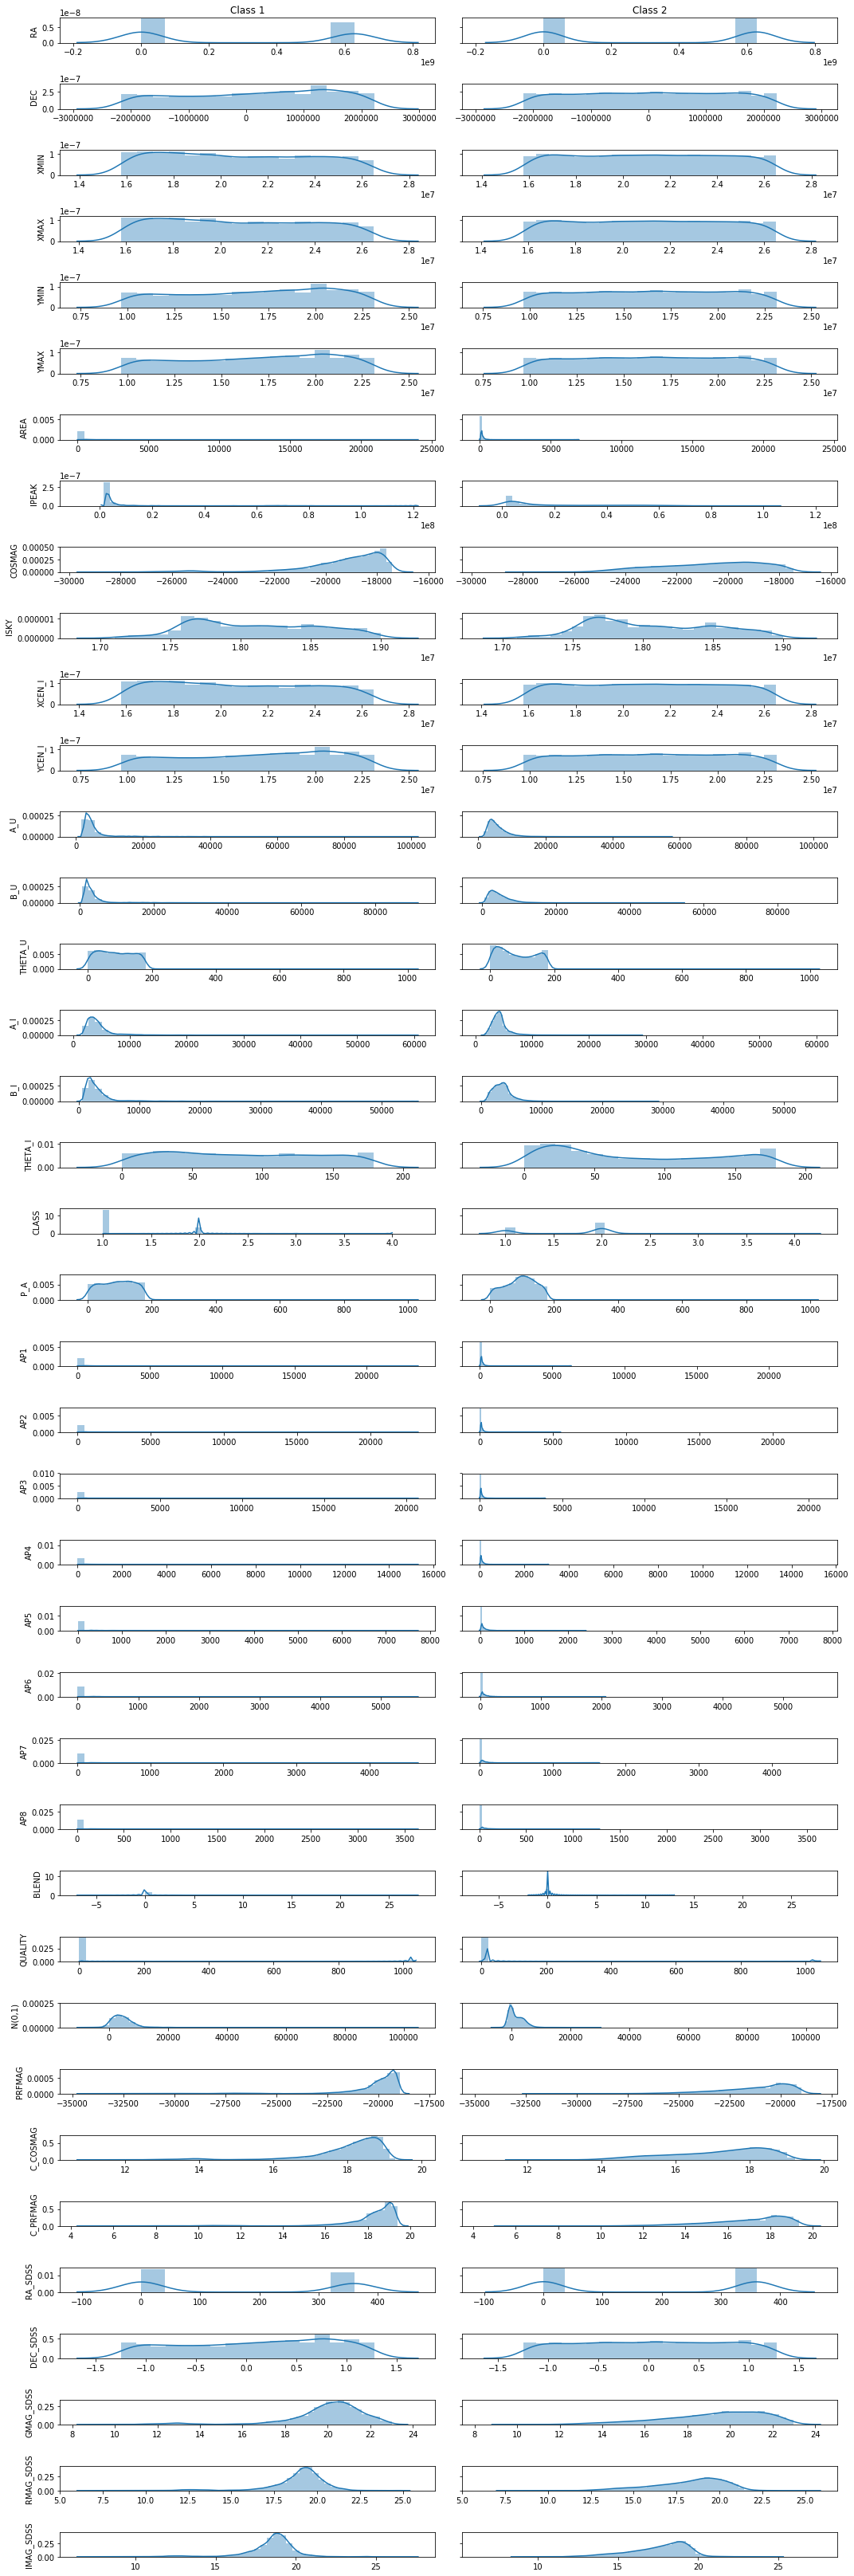

In [11]:
labels = np.array([1,2])
fig, ax = plt.subplots((len(X_train_raw.columns)), labels.size, figsize=(15,45), sharey = 'row', sharex = 'row')


for ii, feat in enumerate(X_train_raw):
    for jj, clas in enumerate(labels):
        sns.distplot(X_train_raw[y_train==clas][feat], ax=ax[ii][jj], kde=True)
        ax[ii][jj].xaxis.label.set_visible(False)
           
[ax[0][ii].set_title("Class {}".format(clas)) for ii, clas in enumerate(labels)]
[ax[ii][0].set_ylabel("{}".format(feat)) for ii, feat in enumerate(X_train_raw)]
        
fig.tight_layout()
plt.show()


In [12]:
X_train = X_train_raw.iloc[:,relevant_indices[0:(len(relevant_indices)-1)]]
X_val = X_val_raw.iloc[:,relevant_indices[0:(len(relevant_indices)-1)]]
X_test = X_test_raw.iloc[:,relevant_indices[0:(len(relevant_indices)-1)]]

In [13]:
#Extracting relevant columns and adding ellips and FF to X datasets
X_train = add_filling_factor(add_ellipticity_df(X_train))
X_val = add_filling_factor(add_ellipticity_df(X_val))
X_test = add_filling_factor(add_ellipticity_df(X_test))
X_train.columns

Index(['AREA', 'IPEAK', 'COSMAG', 'ISKY', 'A_U', 'B_U', 'THETA_U', 'A_I',
       'B_I', 'THETA_I', 'BLEND', 'QUALITY', 'N(0,1)', 'PRFMAG', 'C_COSMAG',
       'C_PRFMAG', 'RA_SDSS', 'DEC_SDSS', 'GMAG_SDSS', 'RMAG_SDSS',
       'IMAG_SDSS', 'ELLIPTICITY', 'FILLING_FACTOR'],
      dtype='object')

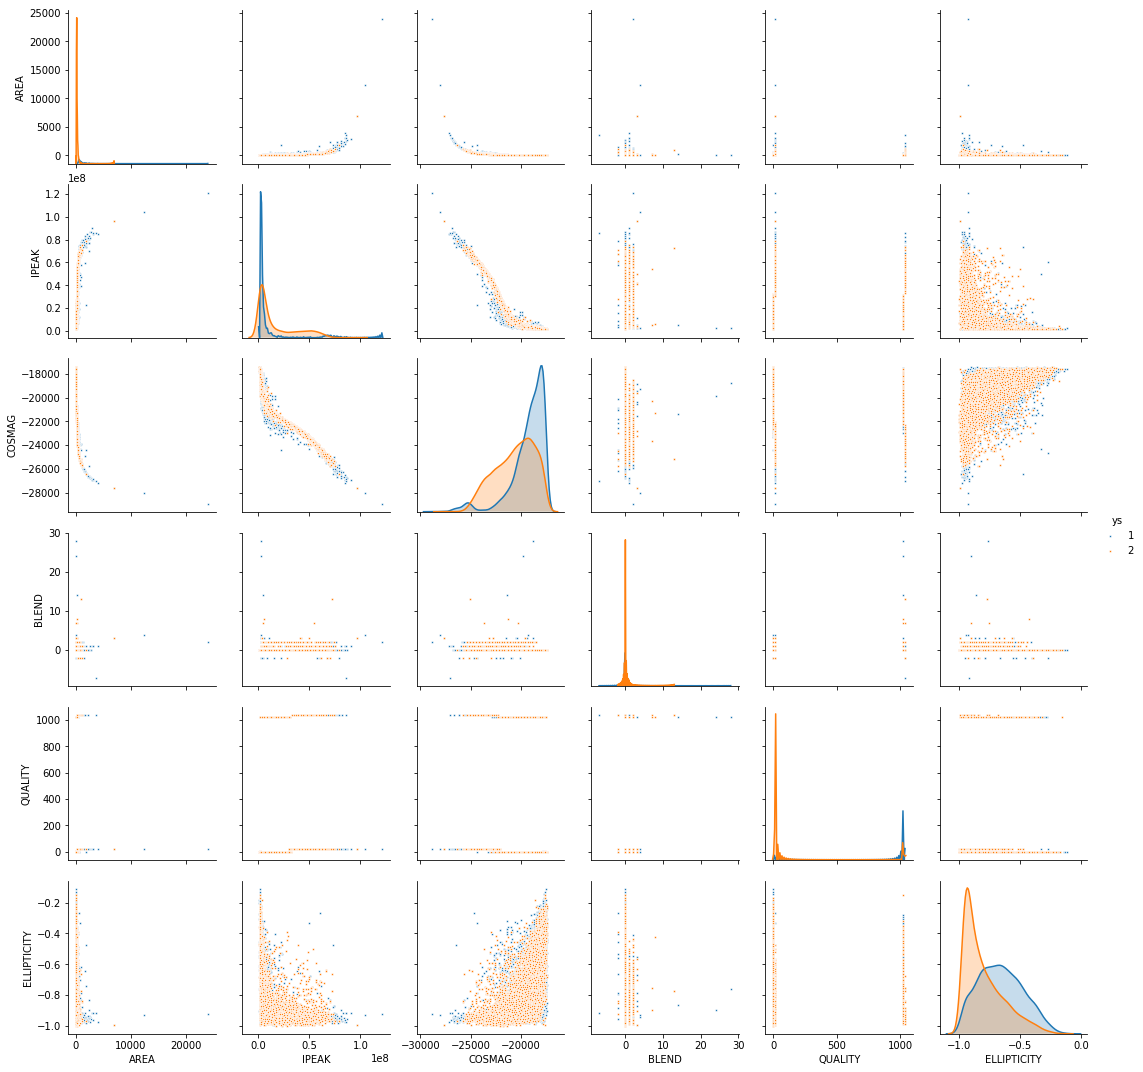

In [14]:
#Identify features that look interesting...
interesting_cols = [0, 1, 2, 10, 11, 21]

# Need to add X_train and y_train back together here
temp = deepcopy(X_train)
temp['ys'] = y_train

sns.pairplot(temp, vars=X_train.columns[interesting_cols], hue='ys', diag_kind = 'kde', plot_kws={'s' : 6})
plt.show()


In [15]:
#Scale dataset and classify
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train.astype('float64'))


Classify_Function(sc.transform(X_train.astype('float64')),
                  y_train,
                  sc.transform(X_val.astype('float64')),
                  y_val)

/home/phil/anaconda3/envs/dme-mini-project/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification performance on validation set:
Logistic Regression, accuracy: 0.865, f1-score: 0.858
Decision Tree, accuracy: 0.866, f1-score: 0.859
Random Forest, accuracy: 0.874, f1-score: 0.868
Neural Net (Multi-layer perceptron), accuracy: 0.898, f1-score: 0.892


In [16]:
#Fitting PCA to scaled training data. 9 PC's
from sklearn.decomposition import PCA
pca = PCA().fit(sc.transform(X_train.astype('float64')))
print(np.cumsum(pca.explained_variance_ratio_))


[0.50578424 0.59482864 0.66887952 0.74084409 0.78810207 0.8310546
 0.87028536 0.90655973 0.93172149 0.95575334 0.96874511 0.97964421
 0.98916626 0.99361685 0.99625626 0.9979985  0.99868875 0.99919649
 0.99959918 0.99979939 0.9999113  0.9999999  1.        ]


In [17]:
#Calculate PCA scores for all datasets. 11 PCs
eleven_pcs = PCA(n_components = 11).fit(sc.transform(X_train.astype('float64')))
pc_scores_train = eleven_pcs.transform(sc.transform(X_train.astype('float64')))
pc_scores_val = eleven_pcs.transform(sc.transform(X_val.astype('float64')))
pc_scores_test = eleven_pcs.transform(sc.transform(X_test.astype('float64')))

In [18]:
#Define function to plot PC directions
def scatter_2d_label(X_2d, y, s=2, alpha=0.5, lw=2):
    """Visualuse a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        plt.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)


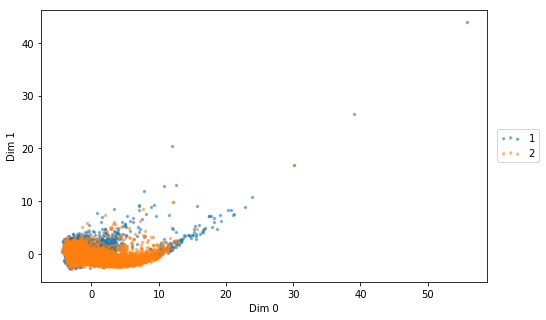

In [19]:
dim_1 = 0# First dimension
dim_2 = 1 # Second dimension
plt.figure(figsize=(8,5)) # Initialise a figure instance with defined size
scatter_2d_label(pc_scores_train[:, [dim_1,dim_2]], y_train)
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
plt.xlabel('Dim {}'.format(dim_1))
plt.ylabel('Dim {}'.format(dim_2))
plt.show()


In [20]:
Classify_Function(pc_scores_train,y_train,pc_scores_val,y_val)

/home/phil/anaconda3/envs/dme-mini-project/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification performance on validation set:
Logistic Regression, accuracy: 0.727, f1-score: 0.700
Decision Tree, accuracy: 0.772, f1-score: 0.758
Random Forest, accuracy: 0.791, f1-score: 0.777
Neural Net (Multi-layer perceptron), accuracy: 0.823, f1-score: 0.814


In [21]:
X_train_raw['N(0,1)'].reset_index(drop=True)

0         -177
1         -991
2         5282
3         -393
4           28
5           94
6         3326
7         3129
8         9881
9          -16
10        -446
11        -685
12        5517
13          83
14         620
15       -1676
16       -1063
17        5017
18        1925
19        2394
20        2672
21        1934
22        6826
23       11050
24        2049
25        2320
26        1907
27        2620
28        4381
29        2499
         ...  
10921     6889
10922     2256
10923     2137
10924      217
10925     -454
10926      784
10927     1206
10928     4816
10929    15485
10930     2191
10931      920
10932     5383
10933     2712
10934     9207
10935     5785
10936      764
10937     -434
10938     4447
10939     2018
10940     4606
10941     1975
10942     7545
10943     2130
10944     4042
10945     -430
10946     1784
10947      -30
10948     4321
10949     3495
10950     8095
Name: N(0,1), Length: 10951, dtype: int64

In [22]:

X_train_raw['N(0,1)'].head()


2092     -177
10341    -991
2238     5282
8282     -393
4903       28
Name: N(0,1), dtype: int64

In [23]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X=enc.fit_transform(X_train_raw['CLASS'].values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(X, columns = ["Class_"+str(int(i)) for i in range(X.shape[1])])
dfOneHot = pd.concat([dfOneHot, X_train_raw['N(0,1)'].reset_index(drop=True)], axis=1,ignore_index=True)
#print(dfOneHot.head())
X_train_SSS = pd.concat([X_train, dfOneHot], axis=1)
X_train_SSS.head()
#X_train_raw['N(0,1)'].head()
#X_train_raw.iloc[0,6]

/home/phil/anaconda3/envs/dme-mini-project/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,AREA,IPEAK,COSMAG,ISKY,A_U,B_U,THETA_U,A_I,B_I,THETA_I,...,GMAG_SDSS,RMAG_SDSS,IMAG_SDSS,ELLIPTICITY,FILLING_FACTOR,0,1,2,3,4
0,161.0,42793408.0,-22923.0,17532226.0,7978.0,6626.0,166.0,4944.0,4524.0,177.0,...,19.127230,17.637123,15.888538,-0.914846,9.694614e-07,0.0,1.0,0.0,0.0,-177.0
1,46.0,5089298.0,-20025.0,18211806.0,4852.0,3506.0,128.0,4419.0,3052.0,133.0,...,19.122244,18.505545,18.302338,-0.690428,8.607465e-07,0.0,1.0,0.0,0.0,-991.0
2,87.0,17260390.0,-21479.0,17841694.0,6028.0,4991.0,119.0,4327.0,3762.0,121.0,...,19.118631,17.716108,17.013582,-0.869193,9.204677e-07,1.0,0.0,0.0,0.0,5282.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,-393.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,28.0


In [24]:
Classify_Function(X_train_SSS,y_train,X_val_SSS,y_val)

NameError: name 'X_val_SSS' is not defined